In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

2024-06-21 17:27:00.955381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 17:27:01.935816: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-21 17:27:01.935929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-06-21 17:27:01.935942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
from xgboost import XGBClassifier
from scipy.linalg import null_space
from sklearn.cross_decomposition import CCA

In [4]:
#from google.colab import drive
import pickle
#drive.mount('/content/drive')

In [5]:
with open('../datasets-ood/chem/train.csv', 'r') as f:
  dataX = np.float32(np.array([line.strip().split(',')[2:] for line in f])[1:])

with open('../datasets-ood/chem/train.csv', 'r') as f:
  dataY = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

X = dataX
Y = dataY

In [6]:
with open('/content/drive/My Drive/LUPA_Projects/Scientific_Discovery/chem_ood_datasets/dataset1/val_id.csv', 'r') as f:
  dataX_val = np.float32(np.array([line.strip().split(',')[2:] for line in f])[1:])

with open('/content/drive/My Drive/LUPA_Projects/Scientific_Discovery/chem_ood_datasets/dataset1/val_id.csv', 'r') as f:
  dataY_val = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])


KeyboardInterrupt



In [ ]:
with open('/content/drive/My Drive/LUPA_Projects/Scientific_Discovery/chem_ood_datasets/dataset1/test_id.csv', 'r') as f:
  dataX_tst = np.float32(np.array([line.strip().split(',')[2:] for line in f])[1:])

with open('/content/drive/My Drive/LUPA_Projects/Scientific_Discovery/chem_ood_datasets/dataset1/test_id.csv', 'r') as f:
  dataY_tst = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

In [7]:
with open('../datasets-ood/chem/test_ood.csv', 'r') as f:
  external_X = np.float32(np.array([line.strip().split(',')[4:] for line in f])[1:])

with open('../datasets-ood/chem/test_ood.csv', 'r') as f:
  external_Y = np.float32(np.array([line.strip().split(',')[1] for line in f])[1:])

In [8]:
X = dataX
Y = dataY

# standardize the data
mu_x = np.mean(X, 0, keepdims=True)
#sigma_x = np.std(X, 0, keepdims=True)
sigma_x = np.ones_like(mu_x)
X = (X-mu_x)/sigma_x

# PCA
XtX = np.matmul(X.T, X)
eigvals, eigvecs = np.linalg.eig(XtX)
sortinds = np.argsort(-eigvals)
V = eigvecs[:, sortinds]

In [9]:
external_X = (external_X-mu_x)/sigma_x
# held_X = (dataX_val-mu_x)/sigma_x
# held_Y = dataY_val
#held_X = (np.concatenate((dataX_val, dataX_tst), 0)-mu_x)/sigma_x
#held_Y = np.concatenate((dataY_val, dataY_tst), 0)

In [10]:
def get_preds(x, dirs, ests, mus=None):
  if mus is None:
    mus = [0.0 for _ in range(len(dirs))]
  pred_array = [e.predict((x-mu)@d) for mu, d, e in zip(mus, dirs, ests)]
  return np.stack(pred_array, -1)

In [11]:
def aggregate_preds(preds):
  mean_pred = np.mean(preds, 1, keepdims=False)
  std_pred = np.std(preds, 1, keepdims=False)
  return np.float32(mean_pred), mean_pred, std_pred

Most Vanilla Ensemble with randomly chosen subset and projects.

In [12]:
splits_rand = []
dirs_rand = []
mus_rand = []
class_rand = []

N_tot = X.shape[0]
Tbase = 2**10

d =  X.shape[1]
ndirs = 128
for vi in range(Tbase):

  print('\n\n\n\n##########\nrand split {}\n##########\n\n\n\n'.format(vi))
  in_range = np.random.rand(N_tot) <= .5
  splits_rand.append(in_range)
  X_train = X[in_range]
  Y_train = Y[in_range]

  mus_rand.append(np.mean(X_train, 0, keepdims=True))
  rdirs = np.random.randn(d, ndirs)
  rdirs = rdirs / np.sqrt(np.sum(rdirs**2, 0, keepdims=True))
  dirs_rand.append(rdirs)

  est = XGBClassifier(n_estimators=40)
  est.fit((X_train-mus_rand[-1])@dirs_rand[-1], Y_train)
  class_rand.append(est)





##########
rand split 0
##########








##########
rand split 1
##########








##########
rand split 2
##########








##########
rand split 3
##########








##########
rand split 4
##########








##########
rand split 5
##########








##########
rand split 6
##########








##########
rand split 7
##########








##########
rand split 8
##########








##########
rand split 9
##########








##########
rand split 10
##########








##########
rand split 11
##########








##########
rand split 12
##########








##########
rand split 13
##########








##########
rand split 14
##########








##########
rand split 15
##########








##########
rand split 16
##########








##########
rand split 17
##########








##########
rand split 18
##########








##########
rand split 19
##########








##########
rand split 20
##########








##########
rand split 21
##########








##########
rand split 22
##########




In [13]:
# extern_preds_rand = get_preds(external_X, dirs_rand[:200], class_rand[:200], mus_rand[:200])
extern_preds_rand = get_preds(external_X, dirs_rand, class_rand, mus_rand)

In [14]:
ens_preds_rand, mp_rand, sp_rand = aggregate_preds(extern_preds_rand)

In [ ]:
threshs = sp_rand
ens_preds = ens_preds_rand
std_threshs = np.linspace(np.min(threshs), np.max(threshs), 20)
reject_rate = [1 - np.mean((threshs<=s)) for s in std_threshs]
accus = [np.mean((ens_preds==external_Y)[(threshs<=s)]) for s in std_threshs]
tps = [np.sum(((external_Y)*(ens_preds==external_Y))[(threshs<=s)]) for s in std_threshs]  # correct and positive
fps = [np.sum(((ens_preds)*(ens_preds!=external_Y))[(threshs<=s)]) for s in std_threshs]  # incorrect and predicted positive
pos = np.sum(external_Y)
recall = [tp/pos for tp in tps]
precision = [tp/(tp+fp) for tp, fp in zip(tps, fps)]
plt.plot(recall, precision, marker='+', c='orange')

plt.plot(recall, precision, marker='+', c='orange')
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.xticks(np.arange(0, 1.01, step=0.05), minor=True)
plt.yticks(np.arange(.6, 1.01, step=0.05))
plt.grid(True, which='both')
plt.xlabel('Recall ({} Positive)'.format(int(pos)))
plt.ylabel('Precision')
plt.title('Precision vs Recall by Thresholding Ensemble Std')
plt.legend(['Precision Vanilla'])

In [36]:
ext_preds = ens_preds_rand > 0.5
testing_Y = external_Y

print("First 10 Predictions: ", ext_preds[:10])
print("Total Positive Preds: ", sum(ext_preds))
print("Total Preds: ", len(ext_preds))
print("% Positive Preds: ", sum(ext_preds) / len(ext_preds))
print()
print("First 10 Ground Truth: ", testing_Y[:10])
print("Total Positive Ground Truth: ", sum(testing_Y))
print("Total Ground Truth: ", len(testing_Y))
print("% Positive Ground Truth: ", sum(testing_Y) / len(testing_Y))
print("Accuracy: ", sum(ext_preds == testing_Y) / len(ext_preds))

First 10 Predictions:  [False False False False  True False False False False False]
Total Positive Preds:  494
Total Preds:  937
% Positive Preds:  0.5272145144076841

First 10 Ground Truth:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total Positive Ground Truth:  421.0
Total Ground Truth:  937
% Positive Ground Truth:  0.44930629669156885

Accuracy:  0.6616862326574173


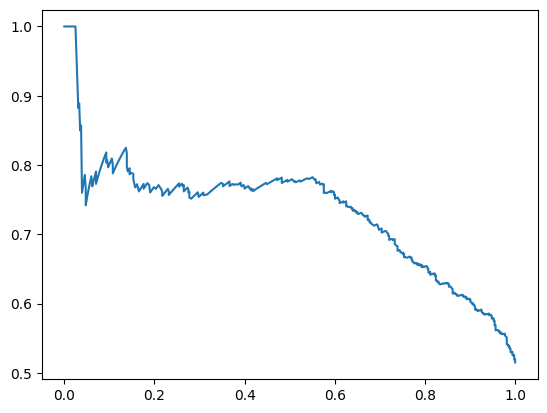

In [15]:
from sklearn.metrics import precision_recall_curve
p, r, thres = precision_recall_curve(external_Y, ens_preds_rand)

plt.plot(r, p)

In [17]:
from sklearn.metrics import precision_recall_curve, auc
auc(r[r<0.2], p[r<0.2]) / np.max(r[r<0.2])

0.8205720584548548